In [1]:
import glob
import tables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from astropy import units as u
from astropy.coordinates import SkyCoord

## Load results file into data frame

In [2]:
T='04yr'
catalog_columns = ['f','colatitude','longitude','amplitude','inclination','polarization','phase','fdot','fddot','sigma_df/f','sigma_colatitude','sigma_longitude','sigma_dA/A','sigma_inclination','sigma_polarization','sigma_phase','sigma_dfdot/fdot','sigma_dfddot/fddot','sigma_Omega','SNR'] 
catalog = pd.read_table(T+"/SigmasAE.dat",delimiter=" ", header=None,index_col=False,names=catalog_columns)
catalog.head()

,f,colatitude,longitude,amplitude,inclination,polarization,phase,fdot,fddot,sigma_df/f,sigma_colatitude,sigma_longitude,sigma_dA/A,sigma_inclination,sigma_polarization,sigma_phase,sigma_dfdot/fdot,sigma_dfddot/fddot,sigma_Omega,SNR
0,0.000212,1.51454,0.837797,1.367850e-21,2.89339,0.106658,4.17682,1.681630e-20,4.891866e-36,1.883476e-10,0.089250,0.083876,5.395456,21.596960,8.638422,1.727640e+01,3.919951e+02,0.0,154.08360,11.742339
1,0.000227,2.55512,2.771070,2.011320e-21,1.40163,0.017058,4.35799,7.452880e-21,8.971106e-37,6.301563e-10,0.123929,0.121817,0.159797,0.085665,0.064930,3.053677e-01,1.948100e-01,0.0,143.20340,7.076005
2,0.000228,2.31479,5.137680,2.022570e-21,2.57318,0.387113,5.68457,2.339130e-20,8.783644e-36,1.144288e-09,0.059684,0.077569,0.150921,0.163121,0.117387,1.172973e-06,7.027902e+02,0.0,68.24274,16.616591
3,0.000255,2.07609,4.019480,1.382810e-21,2.85624,0.893381,0.58787,2.441990e-20,8.578483e-36,1.152242e-09,0.063882,0.068259,2.923702,10.182760,36.083900,7.216466e+01,7.112478e+02,0.0,76.06192,16.313871
4,0.000263,2.34204,3.371870,1.589280e-21,1.12577,1.937670,4.46073,2.186510e-20,6.655086e-36,3.403786e-10,0.093501,0.101929,0.153560,0.121371,0.072465,2.272103e-30,5.772027e-27,0.0,133.83280,21.185693


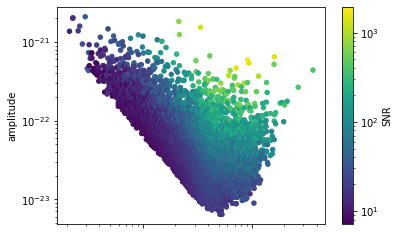

In [3]:
ax = catalog.plot.scatter(x='f',y='amplitude',c='SNR',colormap='viridis',norm=clr.LogNorm())
ax.set_yscale('log')
ax.set_xscale('log')


## Convert from ecliptic to galactic coordinates for sky location and append columns to data frame

In [4]:
def ecliptic_to_galactic(row):

    ecl_lon = row[2]*u.rad
    ecl_lat = (np.pi/2 - row[1])*u.rad

    gal = SkyCoord(ecl_lon,ecl_lat,frame='barycentrictrueecliptic').galactic
    
    gal_lon = gal.l.degree
    gal_lat = gal.b.degree
    
    return pd.Series(dict(l=gal_lon,b=gal_lat))



#catalog['b']=catalog.apply(lambda row: SkyCoord(catalog.longitude*u.rad,(np.pi/2 - catalog.colatitude)*u.rad,frame='barycentrictrueecliptic').galactic.b.degree, axis=1)
catalog =  catalog.join(catalog.apply(lambda row: ecliptic_to_galactic(row), axis=1))


## Convert to distance and chirp mass and append columns to data frame

In [5]:
TSUN = 4.9169e-6
PC = 3.0856775807e16
CLIGHT = 299792458.

def amp_to_distance(row):
    
    f = row[0]
    A = row[3]
    fdot = row[7]

    Mc = 0
    DL = 0
    if(fdot>0):
        Mc = (( fdot * (5./96.) / np.pi**(8./3.) / f**(11./3.))**(3./5.))/TSUN
        DL = ((5./48.)*(fdot/(np.pi**2*f**3*A))*CLIGHT/PC)
    
    return pd.Series(dict(mchirp=Mc,distance=DL))

    
catalog =  catalog.join(catalog.apply(lambda row: amp_to_distance(row), axis=1))
catalog.head()  

,f,colatitude,longitude,amplitude,inclination,polarization,phase,fdot,fddot,sigma_df/f,...,sigma_polarization,sigma_phase,sigma_dfdot/fdot,sigma_dfddot/fddot,sigma_Omega,SNR,l,b,mchirp,distance
0,0.000212,1.51454,0.837797,1.367850e-21,2.89339,0.106658,4.17682,1.681630e-20,4.891866e-36,1.883476e-10,...,8.638422,1.727640e+01,3.919951e+02,0.0,154.08360,11.742339,159.194534,-33.496950,0.913186,132.378587
1,0.000227,2.55512,2.771070,2.011320e-21,1.40163,0.017058,4.35799,7.452880e-21,8.971106e-37,6.301563e-10,...,0.064930,3.053677e-01,1.948100e-01,0.0,143.20340,7.076005,264.805670,1.918278,0.481860,32.472901
2,0.000228,2.31479,5.137680,2.022570e-21,2.57318,0.387113,5.68457,2.339130e-20,8.783644e-36,1.144288e-09,...,0.117387,1.172973e-06,7.027902e+02,0.0,68.24274,16.616591,333.292859,-36.862214,0.944428,99.525353
3,0.000255,2.07609,4.019480,1.382810e-21,2.85624,0.893381,0.58787,2.441990e-20,8.578483e-36,1.152242e-09,...,36.083900,7.216466e+01,7.112478e+02,0.0,76.06192,16.313871,320.340321,14.153458,0.761320,109.353937
4,0.000263,2.34204,3.371870,1.589280e-21,1.12577,1.937670,4.46073,2.186510e-20,6.655086e-36,3.403786e-10,...,0.072465,2.272103e-30,5.772027e-27,0.0,133.83280,21.185693,286.124897,15.025710,0.662786,77.194806


## Plot sky position of sources filtered by localization

Scatter plot of sky location for detections filtered using Boolean `cut` to select sources with sky localizations between intervals `Omega_min` and `Omega_max`, both in square degrees.

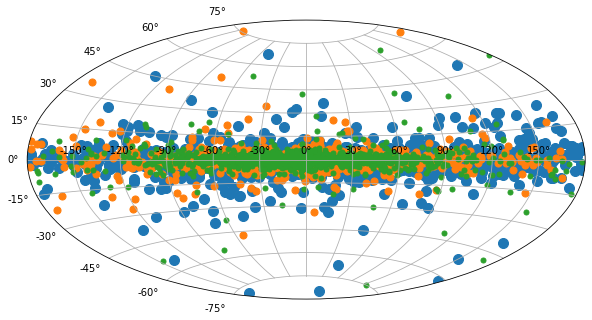

In [6]:
f = plt.figure(figsize=(10,10))
plt.subplot(111, projection='aitoff')
plt.grid(True)

#1-10 square degrees
Omega_min = 1
Omega_max = 10

cut = catalog['sigma_Omega'].between(Omega_min,Omega_max)
gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,s=100)


#0.1-1 square degrees
Omega_min = 0.1
Omega_max = 1

cut = catalog['sigma_Omega'].between(Omega_min,Omega_max)
gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=50)

#0-0.1 square degrees
Omega_min = 0
Omega_max = 0.1

cut = catalog['sigma_Omega'].between(Omega_min,Omega_max)
gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s = 25)

## Use additional cut on inclination

Select for potentially eclipsing binaries.  Use inclinations of `90 +/- 20 degrees` for eclipsing.  Add condition on inclination to `cut`

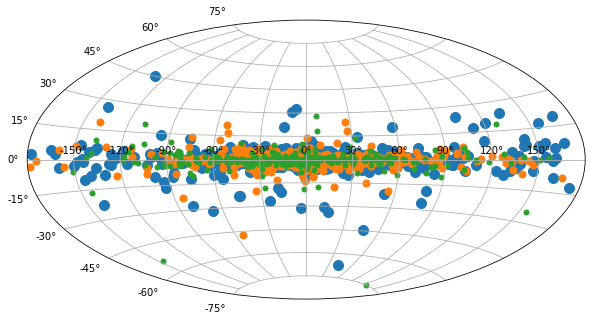

In [7]:
f = plt.figure(figsize=(10,10))
plt.subplot(111, projection='aitoff')
plt.grid(True)

#inclination bounds
imin = (90-20)*np.pi/180
imax = (90+20)*np.pi/180

#1-10 square degrees
Omega_min = 1
Omega_max = 10

cut = catalog['sigma_Omega'].between(Omega_min,Omega_max) \
& catalog['inclination'].between(imin,imax)

gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,s=100)

#0.1-1 square degrees
Omega_min = 0.1
Omega_max = 1

cut = catalog['sigma_Omega'].between(Omega_min,Omega_max) \
& catalog['inclination'].between(imin,imax)

gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=50)

#0-.1 square degrees
Omega_min = 0
Omega_max = 0.1

cut = catalog['sigma_Omega'].between(Omega_min,Omega_max) \
& catalog['inclination'].between(imin,imax)

gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=25)

## Apply  cut on binaries that are nearby

Select for nearby binaries.  The cut is done on binaries that have `df/dt>0` for which we can comput the distance.  Use `1 kpc` as the distance cut.  Add condition to `cut`.

**Note:** We are not (yet) including the measurement errors on `df/dt`, though (a) this information is readily available in `catalog` and (b) such well-localized sources are also likely have well-constrained `df/dt` strictly on SNR grounds, though if the binaries are sufficiently low frequency that might not be the case for short observing times. This is easily fixable by also cutting on `sigma_df/f`

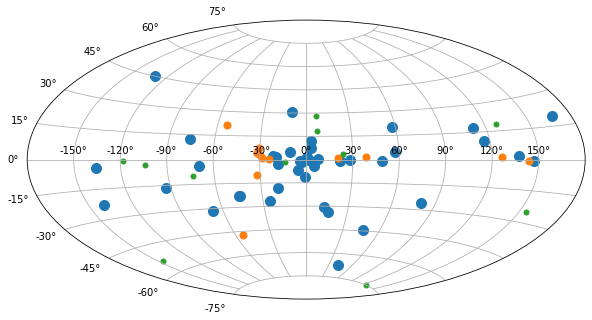

In [8]:
f = plt.figure(figsize=(10,10))
plt.subplot(111, projection='aitoff')
plt.grid(True)

#Distance bounds (in pc)
Dmin = 0
Dmax = 1000 #1kpc, which is good range for Gaia?

#1-10 square degrees
Omega_min = 1
Omega_max = 10

cut = catalog['sigma_Omega'].between(Omega_min,Omega_max) \
& catalog['inclination'].between(imin,imax) \
& catalog['distance'].between(Dmin,Dmax)

gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian,s=100)

#0.1-1 square degrees
Omega_min = 0.1
Omega_max = 1

cut = catalog['sigma_Omega'].between(Omega_min,Omega_max) \
& catalog['inclination'].between(imin,imax) \
& catalog['distance'].between(Dmin,Dmax)

gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=50)

#0-0.1 square degrees
Omega_min = 0
Omega_max = 0.1

cut = catalog['sigma_Omega'].between(Omega_min, Omega_max) \
& catalog['inclination'].between(imin,imax) \
& catalog['distance'].between(Dmin,Dmax)

gal = SkyCoord(catalog[cut]['l'][:],catalog[cut]['b'][:],frame='galactic',unit=u.deg)
plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, s=25)